In [48]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import pickle
from torch import Tensor
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.fft import rfft, rfftfreq, fft, fftfreq
import scipy
import time
import copy
from google.colab import drive

drive.mount('/content/drive')

# Load in Data
with open('/content/drive/MyDrive/CSE 481 Capstone/processed_data.npy', 'rb') as f:
    data = np.load(f)
print(data.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(17920, 4, 32, 32)


In [49]:
# Load in Labels
labels = pd.read_excel("/content/drive/MyDrive/CSE 481 Capstone/metadata_xls/participant_ratings.xls")
print(labels.head())
sub_labels = []
for i in range(len(labels)):
  sub_labels.append([labels.loc[i, 'Valence'] , labels.loc[i, 'Arousal']])
sub_labels = np.array(sub_labels)
print(sub_labels.shape)
print(sub_labels)

# convert to windowed labels
data_labels = np.repeat(sub_labels, 14, axis=0)
print(data_labels.shape)
print(data_labels)

#convert to tensor
#ata = torch.tensor(data)
data = torch.from_numpy(data).float()
data_labels = torch.from_numpy(data_labels).float()
print(data.dtype)
print(data.shape)
dataset = TensorDataset(Tensor(data) , Tensor(data_labels))
print(data[29][1])

   Participant_id  Trial  Experiment_id  ...  Dominance  Liking  Familiarity
0               1      1              5  ...       7.19    6.05          4.0
1               1      2             18  ...       6.94    8.01          4.0
2               1      3              4  ...       6.12    8.06          4.0
3               1      4             24  ...       8.01    8.22          4.0
4               1      5             20  ...       7.19    8.13          1.0

[5 rows x 9 columns]
(1280, 2)
[[6.96 3.92]
 [7.23 7.15]
 [4.94 6.01]
 ...
 [8.05 7.09]
 [4.01 7.17]
 [4.08 5.95]]
(17920, 2)
[[6.96 3.92]
 [6.96 3.92]
 [6.96 3.92]
 ...
 [4.08 5.95]
 [4.08 5.95]
 [4.08 5.95]]
torch.float32
torch.Size([17920, 4, 32, 32])
tensor([[ 1.0000,  0.6335,  0.4222,  ..., -0.0332,  0.3070,  0.1884],
        [ 0.6335,  1.0000,  0.8858,  ..., -0.0963,  0.4528,  0.2397],
        [ 0.4222,  0.8858,  1.0000,  ...,  0.0902,  0.4818,  0.2817],
        ...,
        [-0.0332, -0.0963,  0.0902,  ...,  1.0000,  0.4132,

In [50]:
pre_train_size = int(0.9 * len(dataset))
test_size = len(dataset) - pre_train_size
pre_train_set, test_set = torch.utils.data.random_split(dataset, [pre_train_size, test_size])
train_size = int(0.8 * len(pre_train_set))
val_size = len(pre_train_set) - train_size
print(len(pre_train_set))
print(train_size)
print(val_size)
train_set, val_set = torch.utils.data.random_split(pre_train_set, [train_size, val_size])

batch_size = 128
print(len(train_set), len(val_set), len(test_set))
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
valloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
dataloaders = {
    'train': trainloader,
    'val': valloader,
}

16128
12902
3226
12902 3226 1792


In [51]:
# with auto encoder
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# skipped autoencoder
model = nn.Sequential(
    nn.Conv2d(4, 32, [3, 1]),
    nn.ReLU(),
    nn.Dropout(),
    nn.Conv2d(32, 64, [3, 1]),
    nn.ReLU(), # Maybe not sure
    nn.Dropout(),
    nn.MaxPool2d([3, 3]),
    nn.Flatten(),
    nn.Linear(5760, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 2)
)
model.to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

cuda:0
Sequential(
  (0): Conv2d(4, 32, kernel_size=[3, 1], stride=(1, 1))
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Conv2d(32, 64, kernel_size=[3, 1], stride=(1, 1))
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): MaxPool2d(kernel_size=[3, 3], stride=[3, 3], padding=0, dilation=1, ceil_mode=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=5760, out_features=512, bias=True)
  (9): ReLU()
  (10): Linear(in_features=512, out_features=256, bias=True)
  (11): ReLU()
  (12): Linear(in_features=256, out_features=2, bias=True)
)


In [52]:
def accuracy(input):
  output = np.zeros((len(input)))
  for i in range(len(input)):
    instance = input[i]
    valence = instance[0]
    arousal = instance[1]
    if (valence < 5 and arousal < 5):
      output[i] = 0
    elif (valence < 5 and arousal >= 5):
      output[i] = 1
    elif (valence >= 5 and arousal < 5):
      output[i] = 2
    else:
      output[i] = 3
  return output

In [53]:
since = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 10000.0
all_train_loss = []
all_val_loss = []
num_epochs = 500
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            #print(inputs)
            #print(labels)
            

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                #print(outputs)
                #_, preds = torch.max(outputs, 1)
                #print(preds)
                #print(outputs.dtype)
                #print(labels.dtype)
                loss = loss_func(outputs, labels)
                #print(loss.item())

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()

                #print(running_loss)
                #print(outputs)
                #print(accuracy(outputs))
                #print(accuracy(labels))
                #running_corrects += np.sum(accuracy(outputs) == accuracy(labels)) / inputs.size(0)

        epoch_loss = running_loss / len(dataloaders[phase])
       #epoch_acc = running_corrects / len(dataloaders[phase])

        print('{} Loss: {:.4f}'.format(
            phase, epoch_loss))
        if phase == 'train':
          all_train_loss.append(epoch_loss)
        else:
          all_val_loss.append(epoch_loss)
        # deep copy the model
        # if phase == 'val' and epoch_acc > best_acc:
        #     best_acc = epoch_acc
        #     best_model_wts = copy.deepcopy(model.state_dict())
        if phase == 'val' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

    print()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best Val Loss: {:4f}'.format(best_loss))

# load best model weights
model.load_state_dict(best_model_wts)

torch.save(model.state_dict(), '/content/drive/MyDrive/CSE 481 Capstone/model.pth')

Epoch 0/499
----------
train Loss: 4.9388
val Loss: 17.6996

Epoch 1/499
----------
train Loss: 4.3298
val Loss: 17.5134

Epoch 2/499
----------
train Loss: 4.2731
val Loss: 17.2817

Epoch 3/499
----------
train Loss: 4.1876
val Loss: 17.1131

Epoch 4/499
----------
train Loss: 4.1287
val Loss: 16.9459

Epoch 5/499
----------
train Loss: 4.1046
val Loss: 16.7716

Epoch 6/499
----------
train Loss: 4.0893
val Loss: 16.3878

Epoch 7/499
----------
train Loss: 4.0693
val Loss: 16.2892

Epoch 8/499
----------
train Loss: 4.0446
val Loss: 15.9118

Epoch 9/499
----------
train Loss: 4.0308
val Loss: 15.7037

Epoch 10/499
----------
train Loss: 4.0187
val Loss: 15.3030

Epoch 11/499
----------
train Loss: 3.9956
val Loss: 14.9597

Epoch 12/499
----------
train Loss: 3.9827
val Loss: 14.7942

Epoch 13/499
----------
train Loss: 3.9819
val Loss: 14.3794

Epoch 14/499
----------
train Loss: 3.9633
val Loss: 14.1382

Epoch 15/499
----------
train Loss: 3.9632
val Loss: 13.9423

Epoch 16/499
-----

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  This i

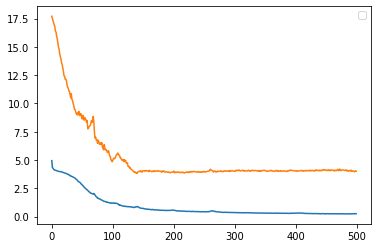

In [54]:
plt.plot(all_train_loss)
plt.plot(all_val_loss)
plt.legend('train', 'val')

In [62]:
datatestiter = iter(testloader)
input_test, labels_test = datatestiter.next()
input_test = input_test.to(device)
labels_test = labels_test.to(device)
model.eval()
output_test = model(input_test)
print(labels_test.shape)
print('outputs',output_test[0:8])
print('labels', labels_test[0:8])
print(np.sum(accuracy(output_test) == accuracy(labels_test)) / len(labels_test))

torch.Size([128, 2])
outputs tensor([[5.0704, 4.5506],
        [5.1730, 6.6542],
        [6.2745, 6.8535],
        [4.2074, 4.8013],
        [3.9224, 4.1815],
        [4.8664, 4.3993],
        [5.8892, 2.8041],
        [5.2885, 5.2225]], device='cuda:0', grad_fn=<SliceBackward>)
labels tensor([[4.1000, 3.1400],
        [2.9400, 7.9700],
        [9.0000, 7.9500],
        [7.0100, 5.9500],
        [4.2700, 6.2600],
        [4.0000, 4.9600],
        [7.5500, 2.8100],
        [6.5600, 5.7200]], device='cuda:0')
0.421875
